In [1]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn.linear_model import Lasso

from src.ushousingcompany.config import data_dir_external
from src.ushousingcompany.config import filename

from src.dataprocessor.data_read import read_data
from src.dataprocessor.mvalues import missing_values
from src.dataprocessor.mvalues import column_analyse
from src.dataprocessor.mvalues import continuous_var
from src.dataprocessor.data_preparation import numeric_catagoric
from src.dataprocessor.data_preparation import dummy_variables
from src.dataprocessor.data_preparation import select_types
from src.dataprocessor.data_preparation import find_scalar
from src.dataprocessor.data_preparation import train_test_data

from src.models.model_training import linear_regression
from src.models.model_training import logistic_regression
from src.models.model_training import lasso_regression
from src.models.model_training import R2_score
from src.models.model_serializer import serializeModel
from src.models.model_serializer import deserializeModel

from src.models.predictions import generateLinRegPredictions

from src.visualization.graphs import saleprice
from src.visualization.graphs import univariate_graph
from src.visualization.graphs import pairplot_graph
from src.visualization.graphs import univariate_analysis_graph
from src.visualization.graphs import bivariate_analysis
from src.visualization.graphs import plot_train_test

import warnings
warnings.filterwarnings('ignore')

In [2]:
absfilename = os.path.abspath(data_dir_external/filename)
absfilename

'/home/naveenkumar/Desktop/CSEProjects/RefactoredProjects/AdvRegression_Lasso_USHousingCompany/data/raw/train.csv'

In [3]:
housing = read_data(absfilename)
housing.head()

2020-11-01 18:51:12,023 	 [INFO | data_read.py:7] > Reading raw data
2020-11-01 18:51:12,157 	 [INFO | data_read.py:11] > Reading raw data completed successfully


Generate new instance


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [4]:
print(housing.columns.size)
housing.info()

81
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 no

In [5]:
print(missing_values(housing))

Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
MasVnrArea        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.534247
BsmtCond          2.534247
BsmtExposure      2.602740
BsmtFinType1      2.534247
BsmtFinSF1        0.000000
BsmtFinType2      2.602740
BsmtFinSF2        0.000000
B

In [6]:
column_analyse(housing , 'FireplaceQu')

NaN    0.472603
Gd     0.260274
TA     0.214384
Fa     0.022603
Ex     0.016438
Po     0.013699
Name: FireplaceQu, dtype: float64

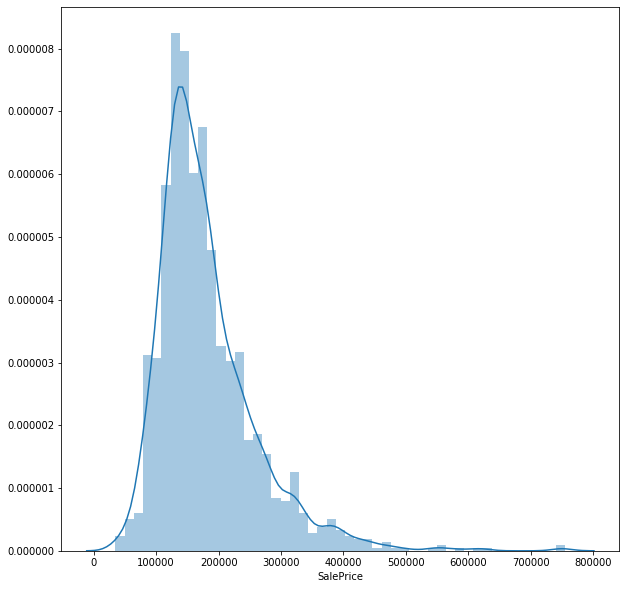

In [7]:
saleprice(housing, 'SalePrice')

In [8]:
housing.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [9]:
num_cols = continuous_var(housing)
num_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [10]:
numeric_cols=['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

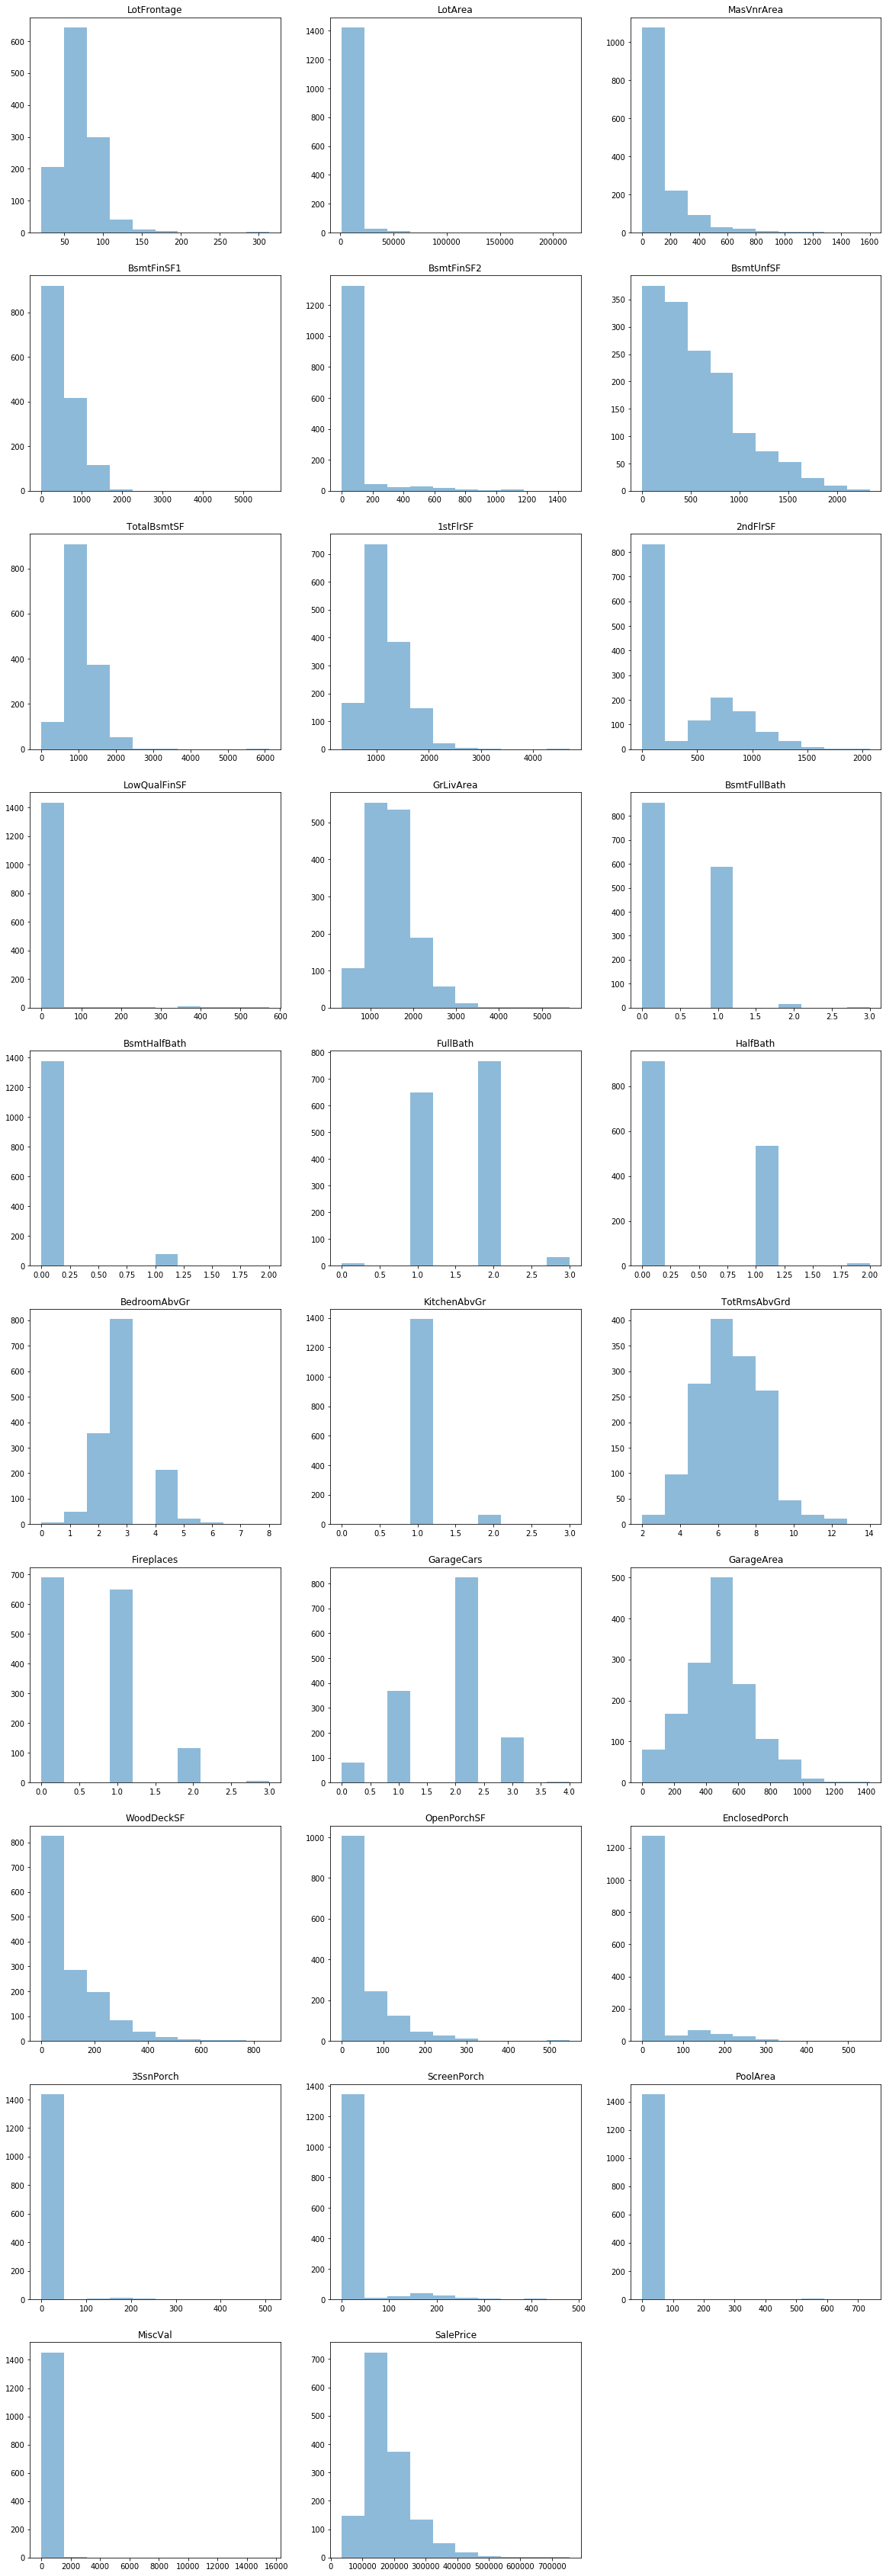

In [11]:
univariate_graph(housing, numeric_cols)

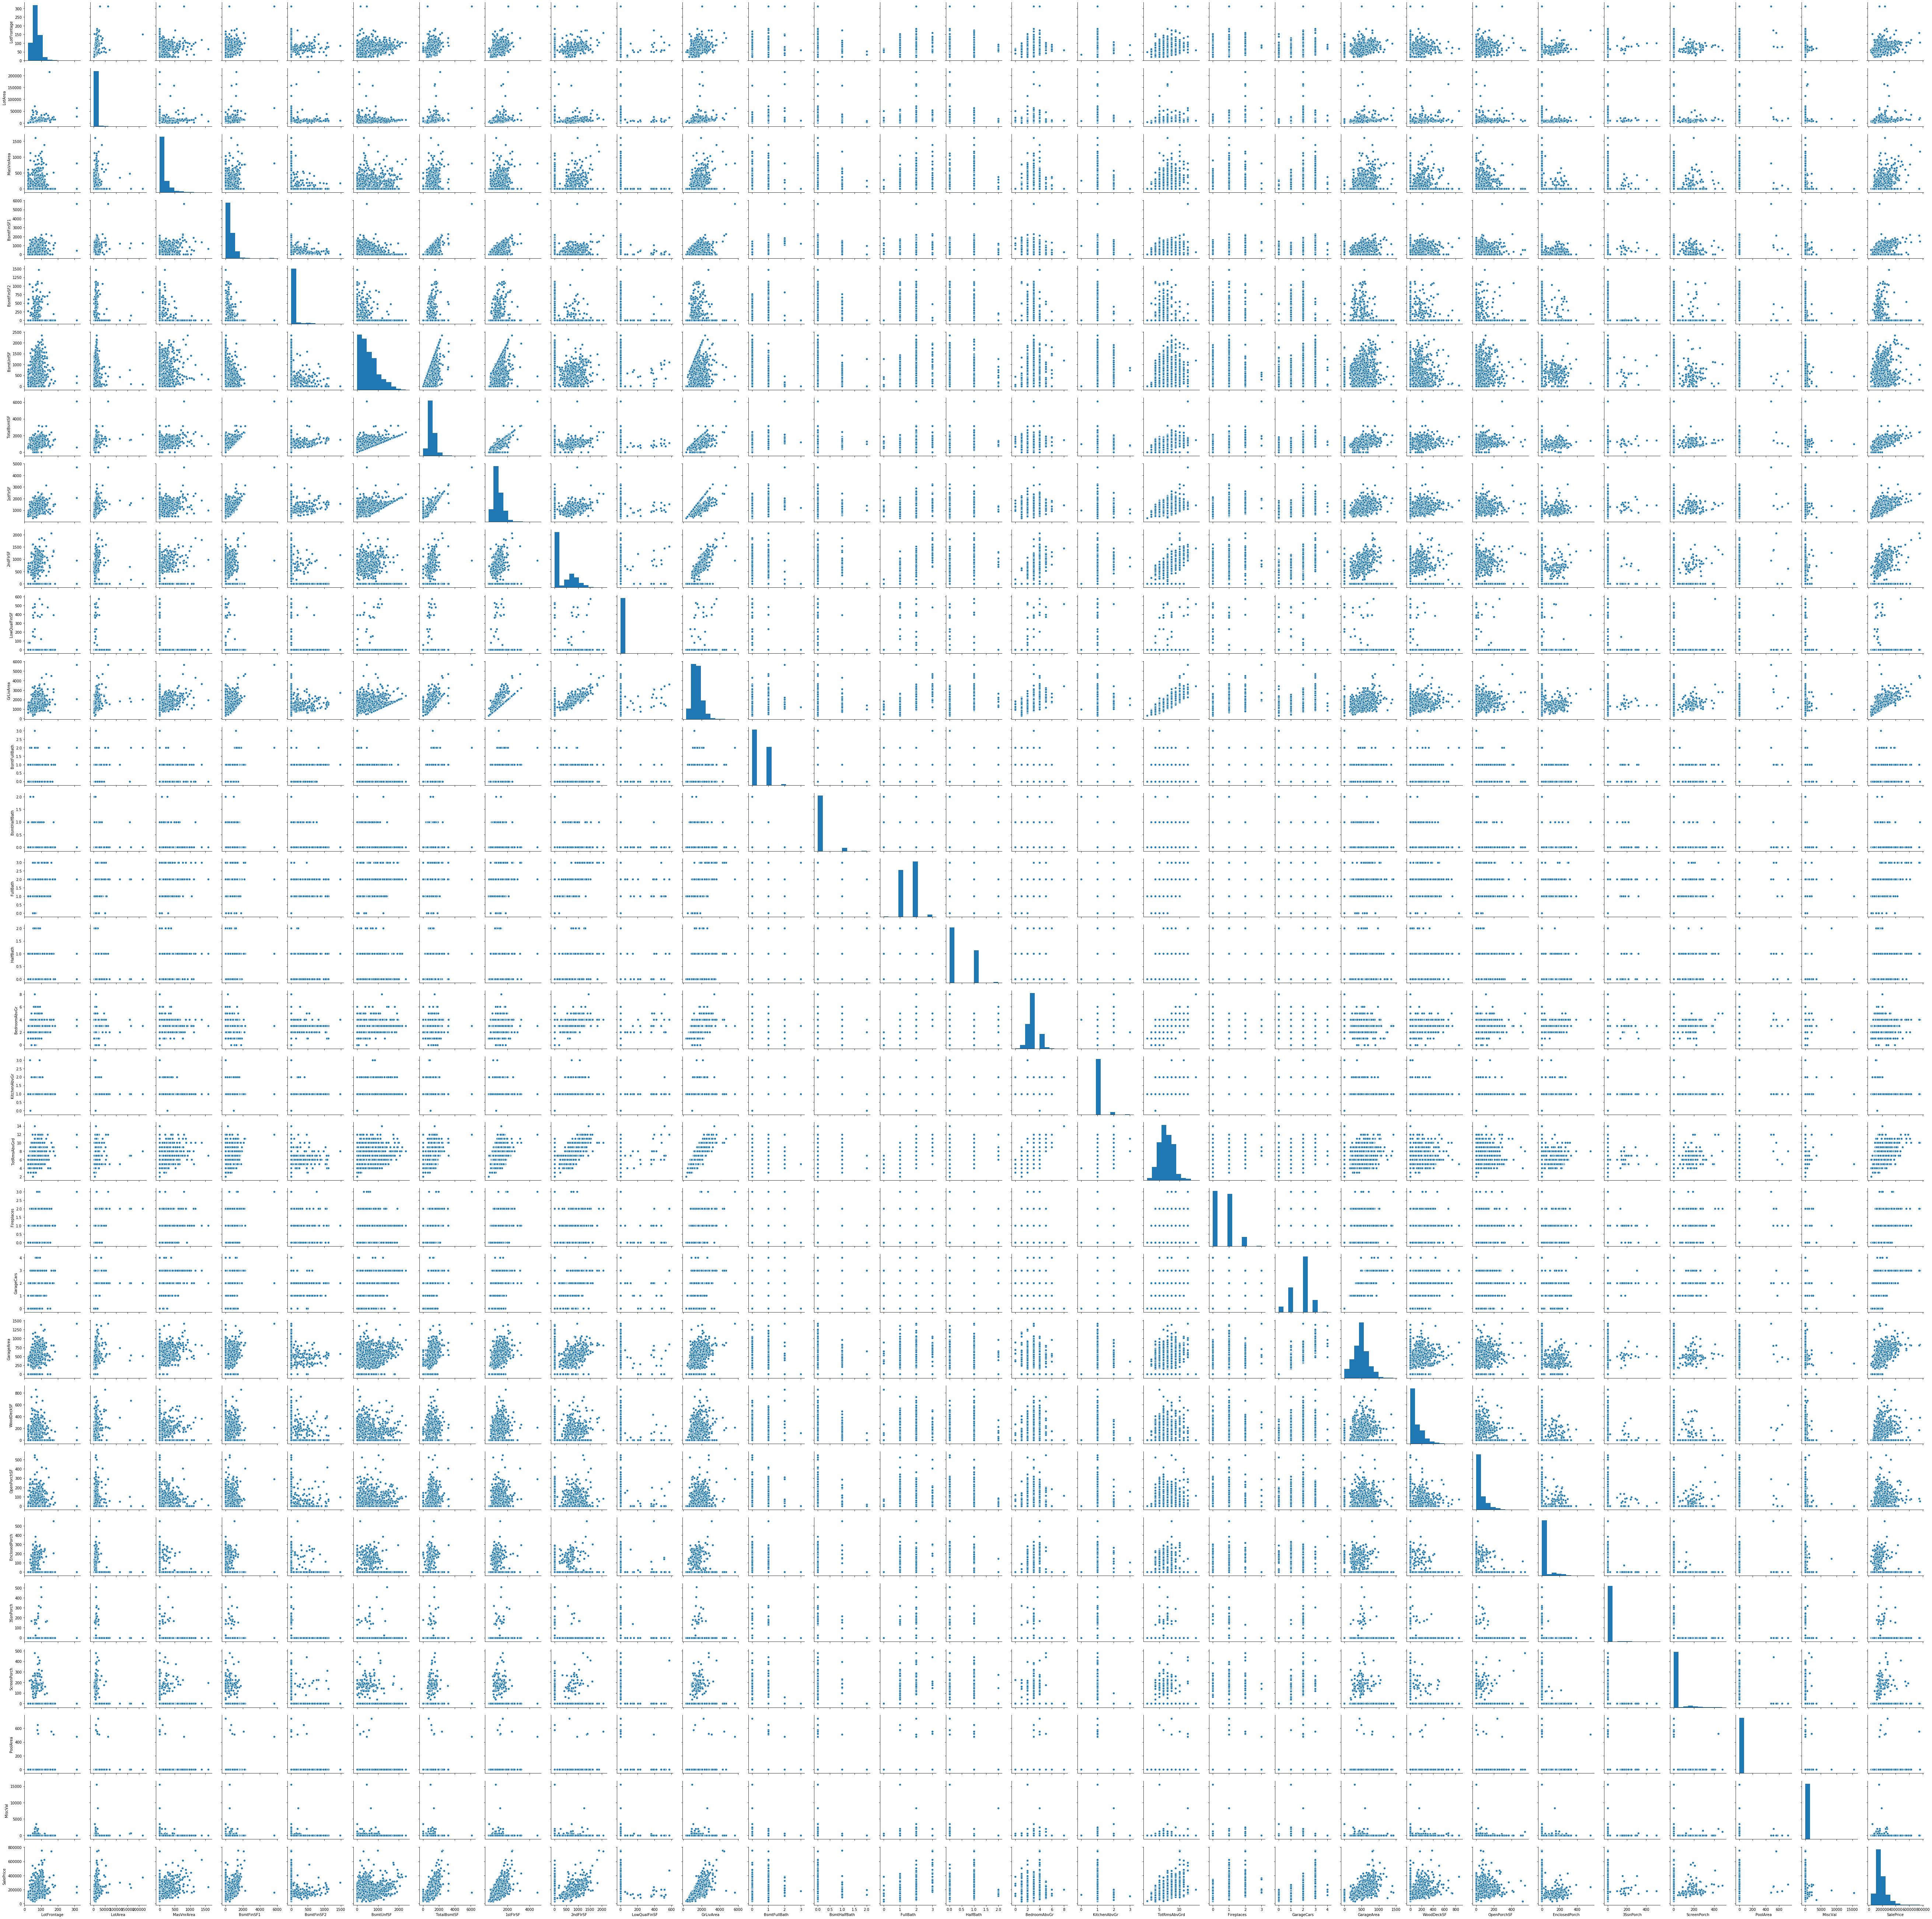

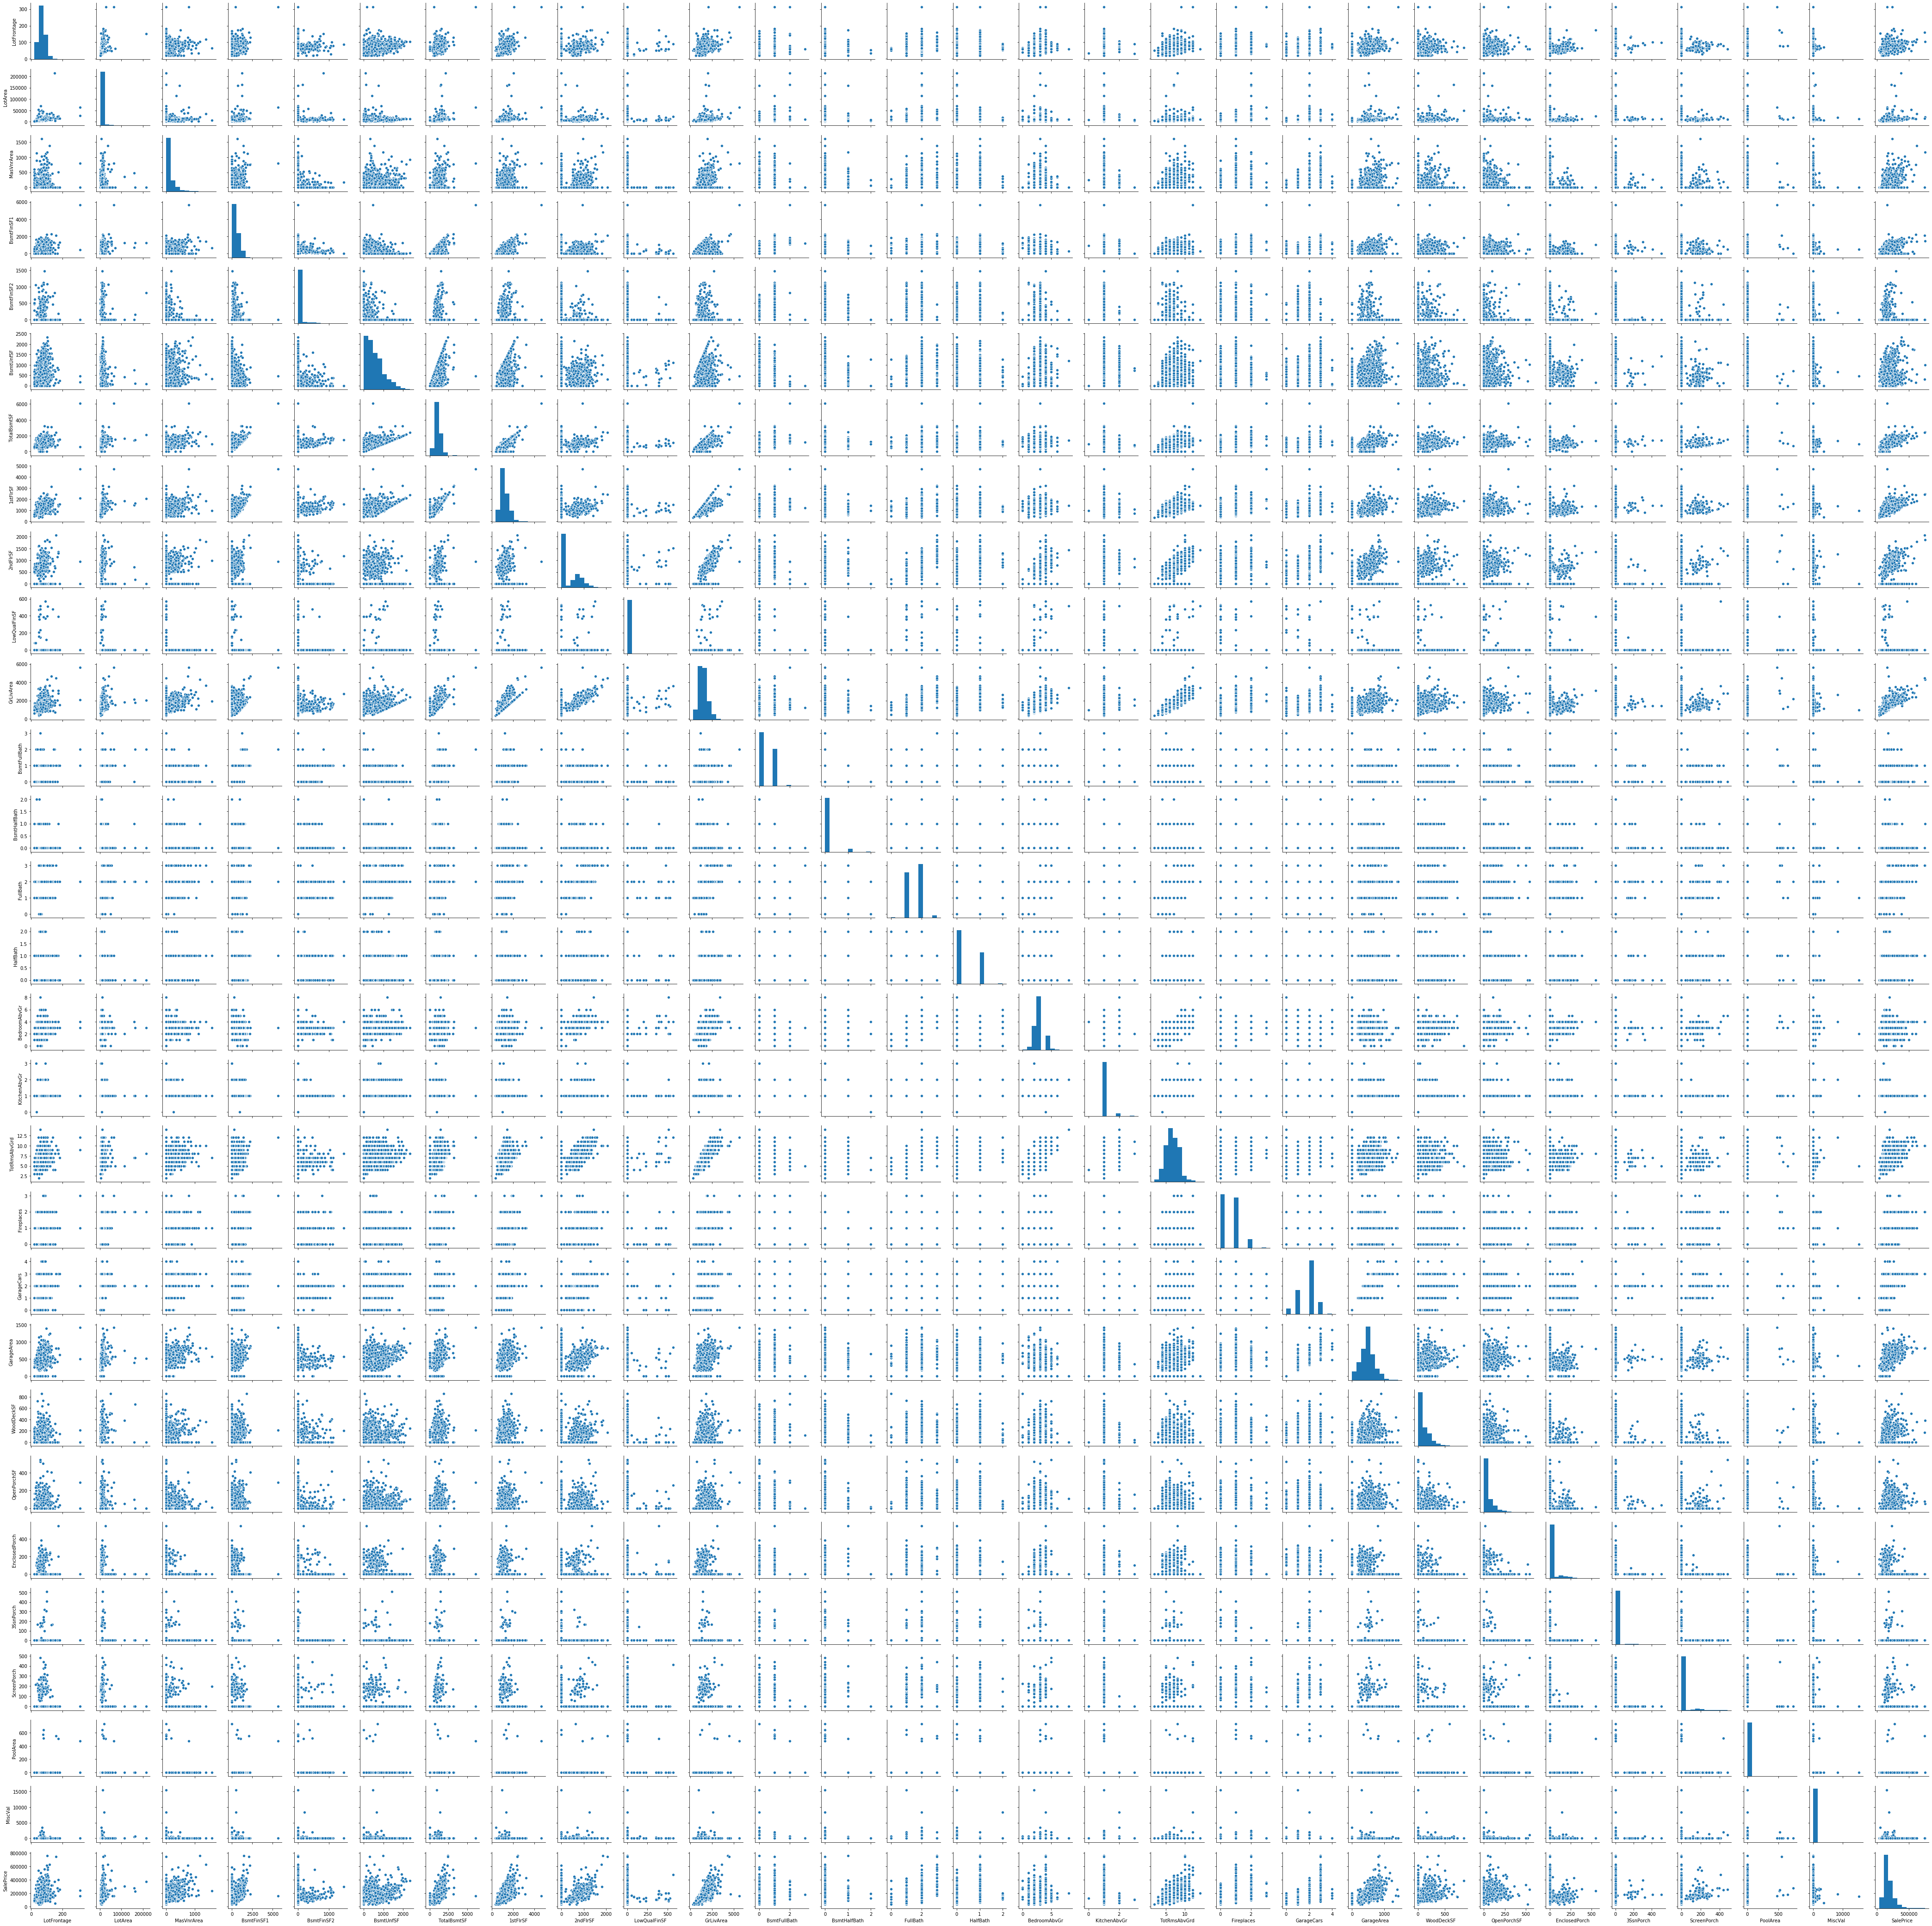

In [12]:
pairplot_graph(housing, numeric_cols)

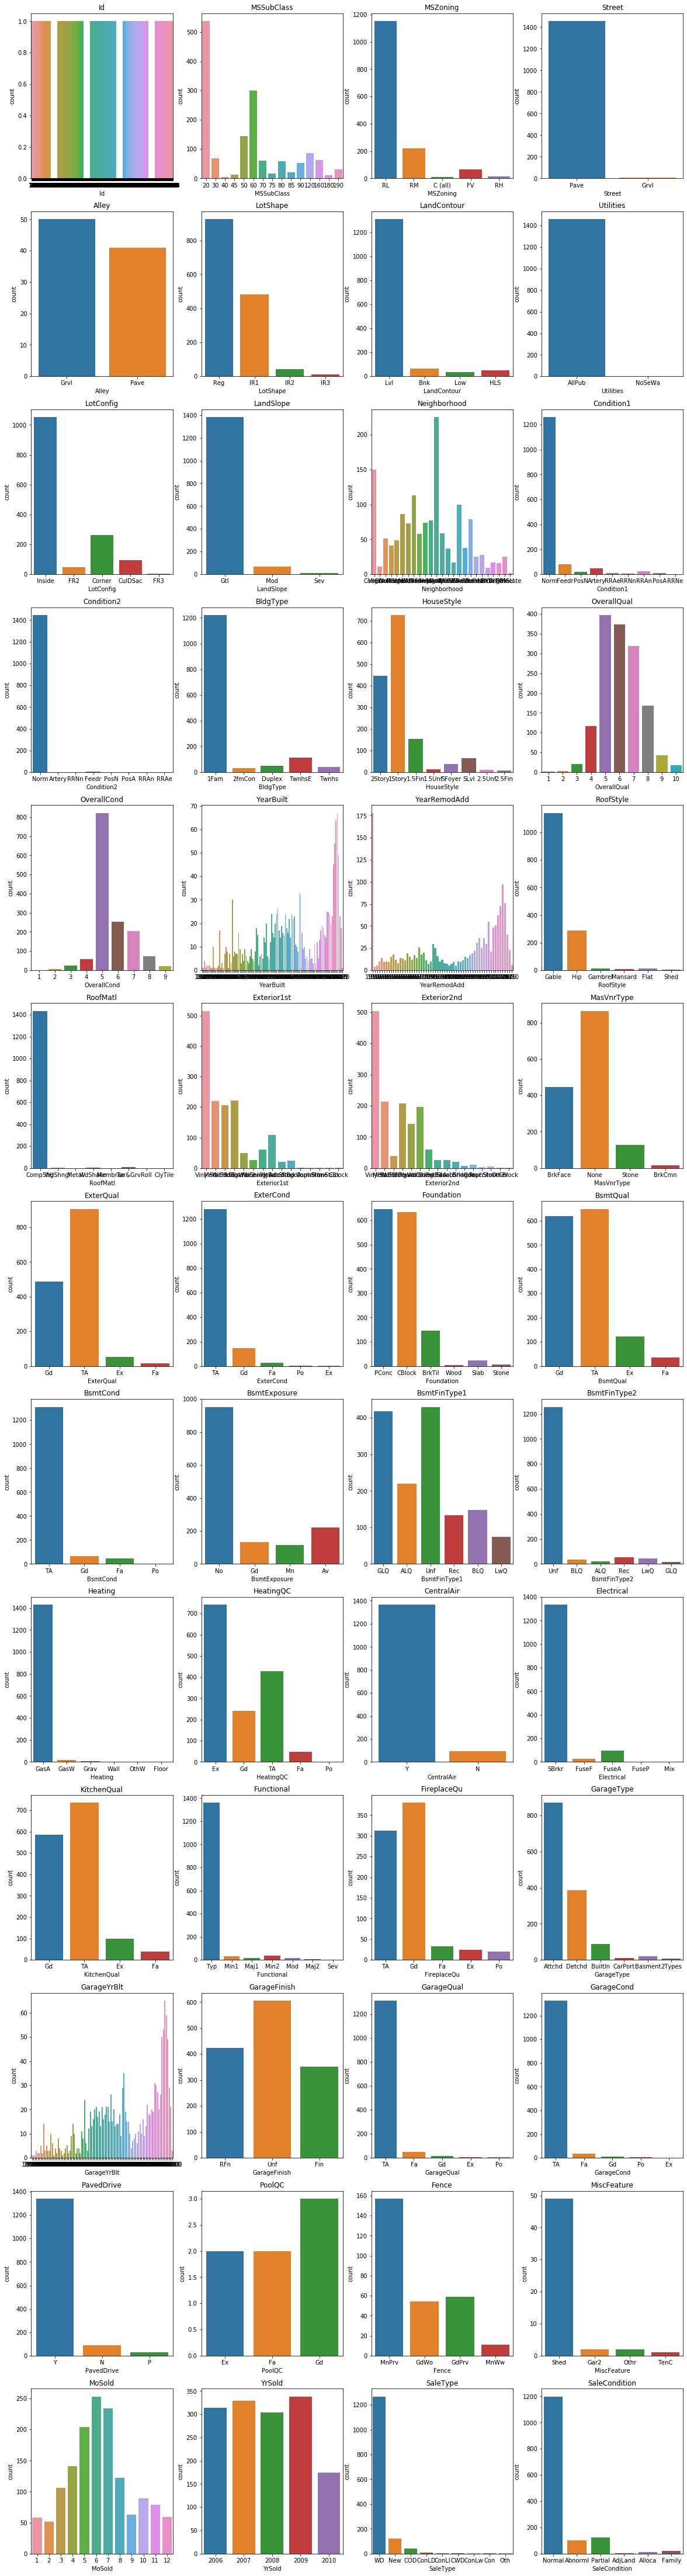

In [13]:
univariate_analysis_graph(housing, numeric_cols)

In [14]:
housing.columns[~housing.columns.isin(numeric_cols)].size

52

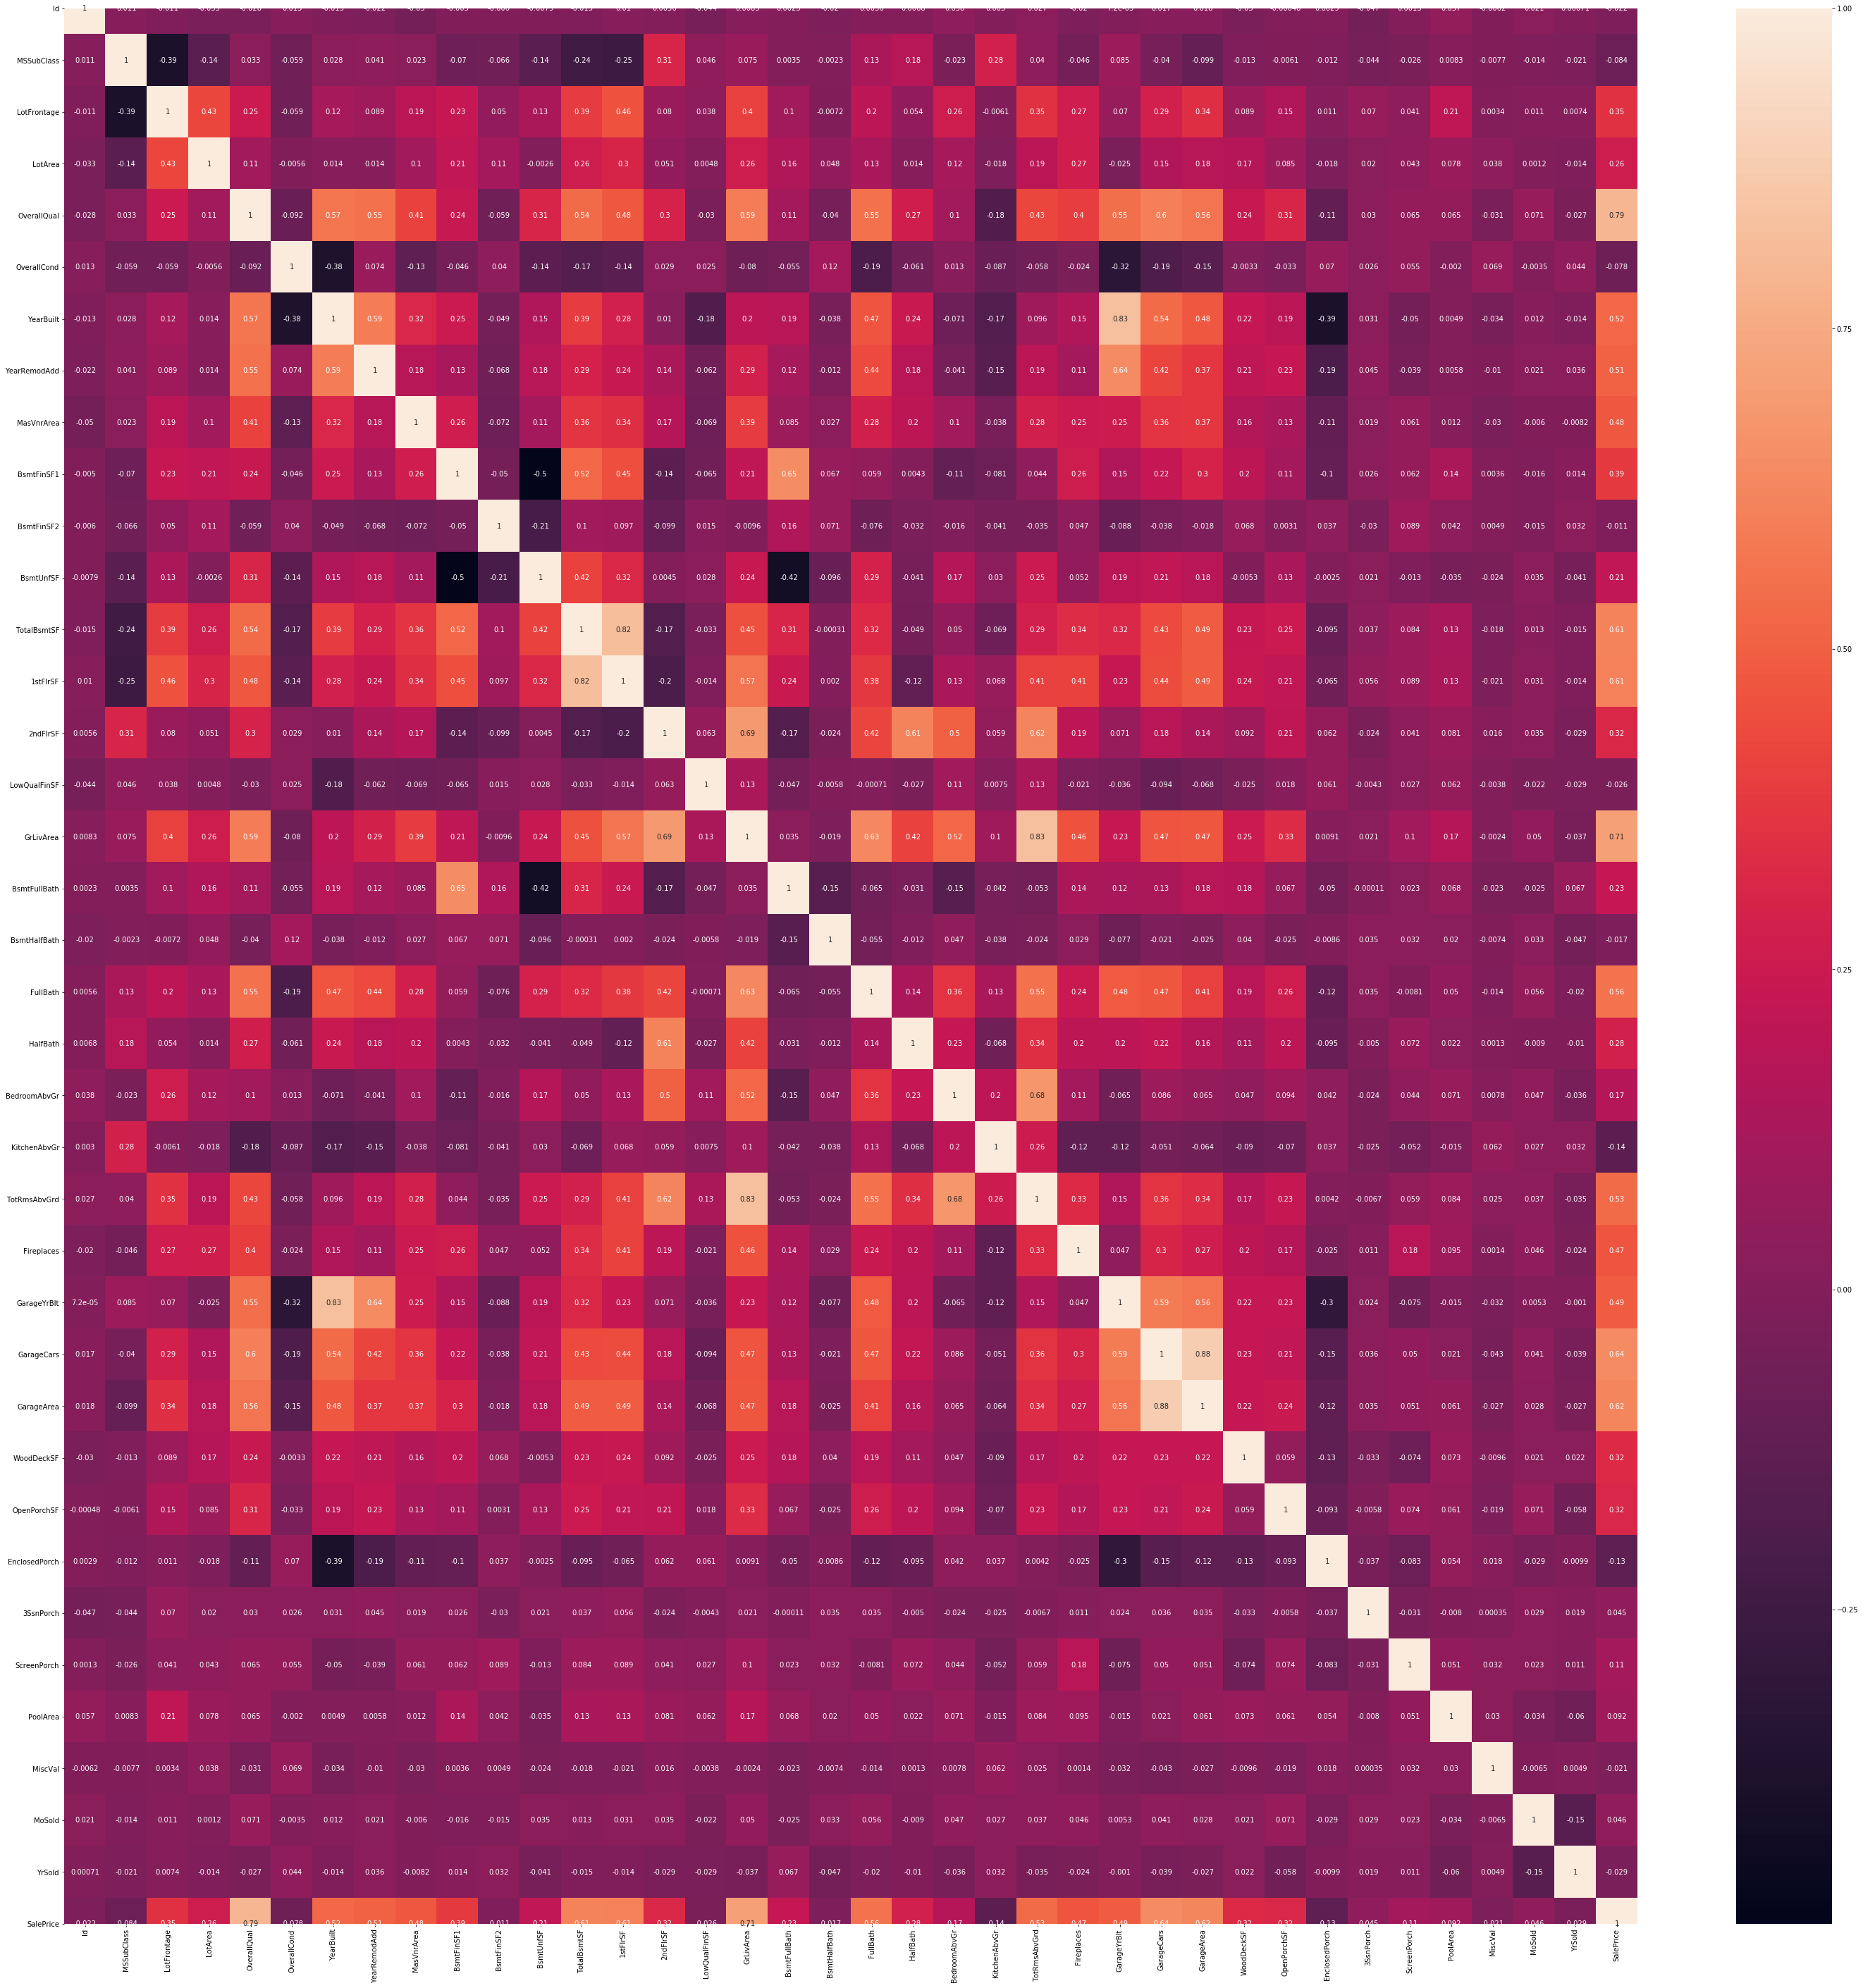

In [15]:
bivariate_analysis(housing)

Points post analysis
. It is clear from the above visuals that there are skewness in few columns,
. There are missing values in columns
. We need to drop columns with high missing values, impute missing values wherever possible
. Scale/transform the numeric data onto a common scale as well as to have a better normal distribution
. Handle outliers for better outcomes

Data Cleaning
. Drop MiscFeature, Fence, PoolQA, Alley
. Impute NaN in FireplaceQu with None
. skew drop:
'LotArea','Street','LandContour','Utilities','LandSlope','Condition1','Condition2','RoofMatl','ExterCond','BsmtFinType2','BsmtFinSF2','Heating','CentralAir','Electrical','LowQualFinSF','BsmntHalfBath','KitchenAbvGr','Functional','GarageQual','GarageCond','PavedDrive','3SsnPorch','EnclosedPorch','ScreenPorch','PoolArea','MiscFeature','MiscVal'
. Check for multicollinearity (remove duplicate attributes)
. Create dummies for categorical variales and drop originals

In [16]:
housing.drop('MiscFeature',axis=1,inplace=True)
housing.drop('Fence',axis=1,inplace=True)
housing.drop('PoolQC',axis=1,inplace=True)
housing.drop('Alley',axis=1,inplace=True)

In [17]:
housing.drop('Id',axis=1,inplace=True)
housing.drop('LotFrontage',axis=1,inplace=True)
housing.columns.size

75

In [18]:
housing.FireplaceQu = housing.FireplaceQu.fillna('None')

In [19]:
housing.FireplaceQu.value_counts()

None    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: FireplaceQu, dtype: int64

In [20]:
#check for missing values again
stillMissing = housing.columns[housing.isnull().any()]
#missing values still found on:MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure,
#BsmtFinTye1, BsmtFinType2, Electrical,GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond

In [21]:
housing[stillMissing].isna().sum()/len(housing)

MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
dtype: float64

In [22]:
# all the attributes on Garage* has missing value if there is no garage
housing.GarageType = housing.GarageType.fillna('None')
housing.GarageFinish = housing.GarageFinish.fillna('None')
housing.GarageQual = housing.GarageQual.fillna('None')
housing.GarageCond = housing.GarageCond.fillna('None')

In [23]:
housing[stillMissing].isna().sum()

MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType       0
GarageYrBlt     81
GarageFinish     0
GarageQual       0
GarageCond       0
dtype: int64

In [24]:
housing.GarageYrBlt.isna().sum()
#most of the garages are build in 2005 and 2006 hence, replacing with 2006
housing.GarageYrBlt = housing.GarageYrBlt.fillna(2006)

In [25]:
# similarity goes to basement as well. 
housing.BsmtQual = housing.BsmtQual.fillna('None')
housing.BsmtCond = housing.BsmtCond.fillna('None')
housing.BsmtExposure = housing.BsmtCond.fillna('None')
housing.BsmtFinType1 = housing.BsmtFinType1.fillna('None')
housing.BsmtFinType2 = housing.BsmtFinType2.fillna('None')

In [26]:
#rest three got ver few rows comparatively; hence we can drop these rows
housing = housing.dropna(axis=0, how='any')

In [27]:
#dummy
#scaling with outliers removed
housing.describe()

MSSubClass        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1451.000000    1451.000000  1451.000000  1451.000000  1451.000000   
mean     56.933150   10507.808408     6.093728     5.579600  1971.092350   
std      42.350366    9992.987081     1.381467     1.113415    30.190266   
min      20.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      20.000000    7537.500000     5.000000     5.000000  1954.000000   
50%      50.000000    9477.000000     6.000000     5.000000  1972.000000   
75%      70.000000   11600.000000     7.000000     6.000000  2000.000000   
max     190.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd  MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
count   1451.000000  1451.00000  1451.000000  1451.000000  1451.000000   
mean    1984.760165   103.75672   442.274983    46.838043   567.197105   
std       20.651334   181.10815   455.369276   161.777324   442.209192   
min     1950.000000     0.00000     0.000000     0.000000     0.000000   
25%     1966.000000     0.00000     0.000000     0.000000   222.000000   
50%     1993.000000     0.00000   381.000000     0.000000   479.000000   
75%     2004.000000   166.00000   707.000000     0.000000   808.000000   
max     2010.000000  1600.00000  5644.000000  1474.000000  2336.000000   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  1451.000000  1451.000000  1451.000000   1451.000000  1451.000000   
mean   1056.310131  1161.551344   346.742247      5.880772  1514.174363   
std     437.914609   385.002532   436.453277     48.771560   525.799521   
min       0.000000   334.000000     0.000000      0.000000   334.000000   
25%     795.000000   882.000000     0.000000      0.000000  1128.000000   
50%     991.000000  1086.000000     0.000000      0.000000  1464.000000   
75%    1297.500000  1391.000000   728.000000      0.000000  1776.000000   
max    6110.000000  4692.000000  2065.000000    572.000000  5642.000000   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   1451.000000   1451.000000  1451.000000  1451.000000   1451.000000   
mean       0.423846      0.057891     1.562371     0.381116      2.866988   
std        0.518842      0.239449     0.550301     0.502574      0.815086   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.000000   
max        3.000000      2.000000     3.000000     2.000000      8.000000   

       KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars  \
count   1451.000000   1451.000000  1451.000000  1451.000000  1451.000000   
mean       1.046175      6.516885     0.612681  1979.896623     1.764990   
std        0.219571      1.626576     0.643443    24.812518     0.748728   
min        0.000000      2.000000     0.000000  1900.000000     0.000000   
25%        1.000000      5.000000     0.000000  1962.000000     1.000000   
50%        1.000000      6.000000     1.000000  1984.000000     2.000000   
75%        1.000000      7.000000     1.000000  2003.000000     2.000000   
max        3.000000     14.000000     3.000000  2010.000000     4.000000   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1451.000000  1451.000000  1451.000000    1451.000000  1451.000000   
mean    472.525155    94.412819    46.422467      21.952447     3.430737   
std     214.171752   125.436852    66.060150      61.108223    29.406940   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     327.500000     0.000000     0.000000       0.000000     0.000000   
50%     478.000000     0.000000    24.000000       0.000000     0.000000   
75%     576.000000   168.000000    68.000000       0.000000     0.000

Data Preparation

In [28]:
numeric_cols, categoric_cols = numeric_catagoric(housing, numeric_cols)

In [29]:
print(len(housing.columns))
#housing.drop('Utilities',axis=1,inplace=True)
print (len(numeric_cols))
print (len(categoric_cols))

75
28
47


In [30]:
housing[categoric_cols].head()

MSSubClass MSZoning Street LotShape LandContour Utilities LotConfig  \
0          60       RL   Pave      Reg         Lvl    AllPub    Inside   
1          20       RL   Pave      Reg         Lvl    AllPub       FR2   
2          60       RL   Pave      IR1         Lvl    AllPub    Inside   
3          70       RL   Pave      IR1         Lvl    AllPub    Corner   
4          60       RL   Pave      IR1         Lvl    AllPub       FR2   

  LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
1       Gtl      Veenker      Feedr       Norm     1Fam     1Story   
2       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
3       Gtl      Crawfor       Norm       Norm     1Fam     2Story   
4       Gtl      NoRidge       Norm       Norm     1Fam     2Story   

   OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
0            7            5       2003          2003     Gable  CompShg   
1            6            8       1976          1976     Gable  CompShg   
2            7            5       2001          2002     Gable  CompShg   
3            7            5       1915          1970     Gable  CompShg   
4            8            5       2000          2000     Gable  CompShg   

  Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual  \
0     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd   
1     MetalSd     MetalSd       None        TA        TA     CBlock       Gd   
2     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd   
3     Wd Sdng     Wd Shng       None        TA        TA     BrkTil       TA   
4     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd   

  BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC  \
0       TA           TA          GLQ          Unf    GasA        Ex   
1       TA           TA          ALQ          Unf    GasA        Ex   
2       TA           TA          GLQ          Unf    GasA        Ex   
3       Gd           Gd          ALQ          Unf    GasA        Gd   
4       TA           TA          GLQ          Unf    GasA        Ex   

  CentralAir Electrical KitchenQual Functional FireplaceQu GarageType  \
0          Y      SBrkr          Gd        Typ        None     Attchd   
1          Y      SBrkr          TA        Typ          TA     Attchd   
2          Y      SBrkr          Gd        Typ          TA     Attchd   
3          Y      SBrkr          Gd        Typ          Gd     Detchd   
4          Y      SBrkr          Gd        Typ          TA     Attchd   

   GarageYrBlt GarageFinish GarageQual GarageCond PavedDrive  MoSold  YrSold  \
0       2003.0          RFn         TA         TA          Y       2    2008   
1       1976.0          RFn         TA         TA          Y       5    2007   
2       2001.0          RFn         TA         TA          Y       9    2008   
3       1998.0          Unf         TA         TA          Y       2    2006   
4       2000.0          RFn         TA         TA          Y      12    2008   

  SaleType SaleCondition  
0       WD        Normal  
1       WD        Normal  
2       WD        Normal  
3       WD       Abnorml  
4       WD        Normal

In [31]:
housing.SaleCondition.value_counts()

Normal     1193
Partial     122
Abnorml     101
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [32]:
add_cols_to_delete = ['Street', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'PavedDrive', 'SaleType', 'SaleCondition']
housing = housing.drop(add_cols_to_delete, axis = 1) 

In [33]:
numeric_cols, categoric_cols = numeric_catagoric(housing, numeric_cols)

In [34]:
print (len(numeric_cols))
print (len(categoric_cols))
print (len(housing.columns))

28
32
60


In [35]:
housing = dummy_variables(housing, categoric_cols)

In [36]:
housing.head()

LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0     8450       196.0         706           0        150          856   
1     9600         0.0         978           0        284         1262   
2    11250       162.0         486           0        434          920   
3     9550         0.0         216           0        540          756   
4    14260       350.0         655           0        490         1145   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710             1             0   
1      1262         0             0       1262             0             1   
2       920       866             0       1786             1             0   
3       961       756             0       1717             1             0   
4      1145      1053             0       2198             1             0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0         2         1             3             1             8           0   
1         2         0             3             1             6           1   
2         2         1             3             1             6           1   
3         1         0             3             1             7           1   
4         2         1             4             1             9           1   

   GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0           2         548           0           61              0          0   
1           2         460         298            0              0          0   
2           2         608           0           42              0          0   
3           3         642           0           35            272          0   
4           3         836         192           84              0          0   

   ScreenPorch  PoolArea  MiscVal  SalePrice  MSSubClass_30  MSSubClass_40  \
0            0         0        0     208500              0              0   
1            0         0        0     181500              0              0   
2            0         0        0     223500              0              0   
3            0         0        0     140000              0              0   
4            0         0        0     250000              0              0   

   MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  \
0              0              0              1              0              0   
1              0              0              0              0              0   
2              0              0              1              0              0   
3              0              0              0              1              0   
4              0              0              1              0              0   

   MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0               0   
1              0              0              0               0   
2              0              0              0               0   
3              0              0              0               0   
4              0              0              0               0   

   MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_FV  MSZoning_RH  \
0               0               0               0            0            0   
1               0               0               0            0            0   
2               0               0               0            0            0   
3               0               0               0            0            0   
4               0               0               0            0            0   

   MSZoning_RL  MSZoning_RM  LotShape_IR2  LotShape_IR3  LotShape_Reg  \
0            1            0             0             0             1   
1            1            0             0             0             1   
2            1            0             0             0             0   
3            1     

In [37]:
X = housing.drop(['SalePrice'], axis=1)

X.head()

LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0     8450       196.0         706           0        150          856   
1     9600         0.0         978           0        284         1262   
2    11250       162.0         486           0        434          920   
3     9550         0.0         216           0        540          756   
4    14260       350.0         655           0        490         1145   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710             1             0   
1      1262         0             0       1262             0             1   
2       920       866             0       1786             1             0   
3       961       756             0       1717             1             0   
4      1145      1053             0       2198             1             0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0         2         1             3             1             8           0   
1         2         0             3             1             6           1   
2         2         1             3             1             6           1   
3         1         0             3             1             7           1   
4         2         1             4             1             9           1   

   GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0           2         548           0           61              0          0   
1           2         460         298            0              0          0   
2           2         608           0           42              0          0   
3           3         642           0           35            272          0   
4           3         836         192           84              0          0   

   ScreenPorch  PoolArea  MiscVal  MSSubClass_30  MSSubClass_40  \
0            0         0        0              0              0   
1            0         0        0              0              0   
2            0         0        0              0              0   
3            0         0        0              0              0   
4            0         0        0              0              0   

   MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  \
0              0              0              1              0              0   
1              0              0              0              0              0   
2              0              0              1              0              0   
3              0              0              0              1              0   
4              0              0              1              0              0   

   MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0               0   
1              0              0              0               0   
2              0              0              0               0   
3              0              0              0               0   
4              0              0              0               0   

   MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_FV  MSZoning_RH  \
0               0               0               0            0            0   
1               0               0               0            0            0   
2               0               0               0            0            0   
3               0               0               0            0            0   
4               0               0               0            0            0   

   MSZoning_RL  MSZoning_RM  LotShape_IR2  LotShape_IR3  LotShape_Reg  \
0            1            0             0             0             1   
1            1            0             0             0             1   
2            1            0             0             0             0   
3            1            0             0             0             0   
4           

In [38]:
# Putting response variable to y
y = housing['SalePrice']

y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [39]:
num_cols, cat_cols = select_types(X)

In [40]:
num_cols.columns

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [41]:
housing = find_scalar(housing, num_cols)

In [42]:
housing.head()

LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0 -0.205996    0.509503    0.579345   -0.289621  -0.943764    -0.457576   
1 -0.090876   -0.573097    1.176868   -0.289621  -0.640635     0.469865   
2  0.074297    0.321705    0.096054   -0.289621  -0.301312    -0.311378   
3 -0.095881   -0.573097   -0.497076   -0.289621  -0.061524    -0.686010   
4  0.375612    1.360116    0.467309   -0.289621  -0.174632     0.202598   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0 -0.793908  1.162628     -0.120619   0.372562      1.110846     -0.241851   
1  0.260994 -0.794728     -0.120619  -0.479767     -0.817189      3.935838   
2 -0.627618  1.190131     -0.120619   0.517154      1.110846     -0.241851   
3 -0.521089  0.938013     -0.120619   0.385880      1.110846     -0.241851   
4 -0.043005  1.618733     -0.120619   1.300993      1.110846     -0.241851   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0  0.795528  1.231851      0.163244      -0.21037      0.912116   -0.952520   
1  0.795528 -0.758590      0.163244      -0.21037     -0.317884    0.602156   
2  0.795528  1.231851      0.163244      -0.21037     -0.317884    0.602156   
3 -1.022285 -0.758590      0.163244      -0.21037      0.297116    0.602156   
4  0.795528  1.231851      1.390532      -0.21037      1.527117    0.602156   

   GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0    0.313988    0.352525   -0.752932     0.220747      -0.359363  -0.116704   
1    0.313988   -0.058502    1.623585    -0.702973      -0.359363  -0.116704   
2    0.313988    0.632770   -0.752932    -0.066969      -0.359363  -0.116704   
3    1.650046    0.791576   -0.752932    -0.172970       4.093291  -0.116704   
4    1.650046    1.697704    0.778247     0.569034      -0.359363  -0.116704   

   ScreenPorch  PoolArea   MiscVal  SalePrice  MSSubClass_30  MSSubClass_40  \
0    -0.271106 -0.068905 -0.087961     208500              0              0   
1    -0.271106 -0.068905 -0.087961     181500              0              0   
2    -0.271106 -0.068905 -0.087961     223500              0              0   
3    -0.271106 -0.068905 -0.087961     140000              0              0   
4    -0.271106 -0.068905 -0.087961     250000              0              0   

   MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  \
0              0              0              1              0              0   
1              0              0              0              0              0   
2              0              0              1              0              0   
3              0              0              0              1              0   
4              0              0              1              0              0   

   MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0               0   
1              0              0              0               0   
2              0              0              0               0   
3              0              0              0               0   
4              0              0              0               0   

   MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_FV  MSZoning_RH  \
0               0               0               0            0            0   
1               0               0               0            0            0   
2               0               0               0            0            0   
3               0               0               0            0            0   
4               0               0               0            0            0   

   MSZoning_RL  MSZoning_RM  LotShape_IR2  LotShape_IR3  LotShape_Reg  \
0            1            0             0             0             1   
1            1            0             0             0             1   
2            1            0             0             0             0   
3       

In [43]:
X_train, X_test, y_train, y_test = train_test_data(X, y)

In [44]:
X.columns.size

483

Model Building and Evaluation
Forward Feature Selection

In [45]:
y_pred = linear_regression(X_train, X_test, y_train, y_test)

Selected features:  ['GrLivArea'] 
AIC:  22241.526995143882 
BIC:  22251.372282926834
Selected features:  ['GrLivArea', 'TotalBsmtSF'] 
AIC:  21881.27002773804 
BIC:  21896.037959412468
Selected features:  ['GrLivArea', 'TotalBsmtSF', 'ExterQual_TA'] 
AIC:  21635.377446025977 
BIC:  21655.06802159188
Selected features:  ['GrLivArea', 'TotalBsmtSF', 'ExterQual_TA', 'OverallQual_9'] 
AIC:  21536.480209231548 
BIC:  21561.093428688928
Selected features:  ['GrLivArea', 'TotalBsmtSF', 'ExterQual_TA', 'OverallQual_9', 'GarageArea'] 
AIC:  21459.770322945657 
BIC:  21489.30618629451
Selected features:  ['GrLivArea', 'TotalBsmtSF', 'ExterQual_TA', 'OverallQual_9', 'GarageArea', 'KitchenAbvGr'] 
AIC:  21399.215352166364 
BIC:  21433.673859406696
Selected features:  ['GrLivArea', 'TotalBsmtSF', 'ExterQual_TA', 'OverallQual_9', 'GarageArea', 'KitchenAbvGr', 'OverallQual_8'] 
AIC:  21350.04465207998 
BIC:  21389.425803211787
Selected features:  ['GrLivArea', 'TotalBsmtSF', 'ExterQual_TA', 'Overall

In [46]:
print("\n\nFinal r-squared: ", metrics.r2_score(y_test, y_pred))



Final r-squared:  0.8098280397619317


Lasso Regression

In [47]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
folds=5

In [48]:
model_cv = lasso_regression(params, folds)

In [49]:
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  3.2min finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [50]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       1.437815      0.113655         0.019604        0.000196      0.0001   
1       1.419128      0.077722         0.019532        0.000080       0.001   
2       1.425152      0.097217         0.019786        0.000282        0.01   
3       1.442457      0.077578         0.019551        0.000101        0.05   
4       1.466179      0.087606         0.019534        0.000075         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}      -32976.205931      -37673.662757      -35119.033682   
1   {'alpha': 0.001}      -32970.441362      -37657.782178      -35109.918758   
2    {'alpha': 0.01}      -32924.711031      -37525.830173      -35021.613319   
3    {'alpha': 0.05}      -32793.809276      -37135.589298      -34861.316877   
4     {'alpha': 0.1}      -32630.964196      -36836.016855      -34753.438964   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0      -45512.276640      -36926.010338    -37641.437870     4256.521817   
1      -45504.685483      -36929.304738    -37634.426504     4255.927992   
2      -45441.104828      -36962.735940    -37575.199058     4252.008019   
3      -45221.983689      -36984.586177    -37399.457064     4221.085500   
4      -45006.182493      -36887.301350    -37222.780772     4195.852799   

   rank_test_score  split0_train_score  split1_train_score  \
0               28        -9134.471301       -13555.254343   
1               27        -9134.434417       -13555.176099   
2               26        -9134.203951       -13554.451380   
3               25        -9135.443264       -13553.412454   
4               24        -9137.951191       -13553.466189   

   split2_train_score  split3_train_score  split4_train_score  \
0       -13374.733626       -13042.288376       -12682.105246   
1       -13374.663734       -13042.239238       -12682.061697   
2       -13374.081998       -13041.894152       -12681.747823   
3       -13373.015392       -13042.756640       -12681.047907   
4       -13372.624437       -13046.452083       -12682.626428   

   mean_train_score  std_train_score  
0     -12357.770578      1638.999514  
1     -12357.715037      1638.988087  
2     -12357.275861      1638.859404  
3     -12357.135131      1638.132288  
4     -12358.624066      1637.477519

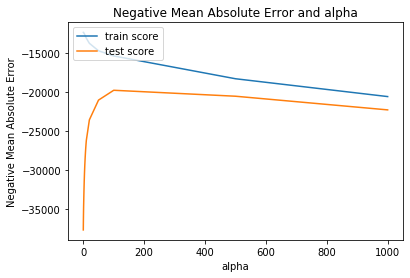

In [51]:
plot_train_test(cv_results)

In [52]:
alpha =100

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)

Lasso(alpha=100)

In [53]:
lasso.coef_

array([ 3.91957268e-01,  1.33227789e+01,  2.34702576e+00, -8.62444970e-01,
        1.28498305e+00,  7.63466757e-01,  3.29954433e+01,  4.02391612e+01,
        8.31385252e+00,  4.51559112e+00,  9.05020360e+03, -0.00000000e+00,
        7.02105102e+03,  4.96021542e+03, -0.00000000e+00, -2.31225194e+04,
        2.68515219e+03,  4.51365950e+03,  2.09727565e+04, -2.71682699e+01,
        2.44554955e+01, -6.46535553e+00,  7.96711810e+00,  6.47157935e+01,
        4.94982691e+01,  3.69573227e+00, -7.78823551e+00, -4.26567736e+03,
        0.00000000e+00,  0.00000000e+00, -2.45809416e+02, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.94377167e+02,  0.00000000e+00,
        0.00000000e+00, -7.86019614e+03, -7.39570125e+03,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.74242160e+03,
       -0.00000000e+00,  6.60871932e+03, -1.31215685e+04, -1.92447294e+02,
        1.95710707e+04,  1.87944933e+04,  1.38321160e+04, -0.00000000e+00,
        7.93911184e+03, -

In [54]:
df = pd.DataFrame(X_train.columns)
df['Coef'] = lasso.coef_

In [55]:
df = df.rename(columns={0: 'colName'})
df[df.colName=='LotArea'].Coef

0    0.391957
Name: Coef, dtype: float64

In [56]:
df.head()

colName       Coef
0     LotArea   0.391957
1  MasVnrArea  13.322779
2  BsmtFinSF1   2.347026
3  BsmtFinSF2  -0.862445
4   BsmtUnfSF   1.284983

In [57]:
len(df[df.Coef!=0])

148

In [58]:
df1 = df[df.Coef!=0]
df1.head()

colName       Coef
0     LotArea   0.391957
1  MasVnrArea  13.322779
2  BsmtFinSF1   2.347026
3  BsmtFinSF2  -0.862445
4   BsmtUnfSF   1.284983

In [59]:
df1 = df1.sort_values(by=['Coef'],ascending=False)
df1.head(10)

colName          Coef
107        OverallQual_10  78795.989832
106         OverallQual_9  73929.334774
70   Neighborhood_NoRidge  32271.077942
105         OverallQual_8  30899.276918
458    GarageYrBlt_2009.0  30485.530668
71   Neighborhood_NridgHt  27112.092846
286     YearRemodAdd_2010  22410.578413
77   Neighborhood_StoneBr  21549.945938
18             GarageCars  20972.756532
61   Neighborhood_Crawfor  19972.429078

In [60]:
serializeModel(df)

2020-11-01 19:30:51,269 	 [INFO | model_serializer.py:11] > model serializer started
2020-11-01 19:30:51,289 	 [INFO | model_serializer.py:15] > model serializer completed successfully


In [61]:
df = deserializeModel()

2020-11-01 19:30:51,425 	 [INFO | model_serializer.py:20] > model deserializer started
2020-11-01 19:30:51,434 	 [INFO | model_serializer.py:24] > model deserializer completed successfully


#### Model Predictions

##### Train set predictions

In [62]:
y_pred_train = generateLinRegPredictions(df, X_train, y_train)
y_pred_train.head()

SalePrice      predicted
0     109900   80756.916718
1     135960   75531.646182
2     392500  231412.329877
3     159950   97301.925363
4     176432  139106.687402

#### Test set predictions

In [63]:
y_pred_test = generateLinRegPredictions(df, X_test, y_test)
y_pred_test.head()

SalePrice      predicted
0     134000   95476.737687
1     232600  161469.657210
2     162000  130804.043591
3     135900   97849.634661
4     180000  129992.604885

### Model Evaluation

In [64]:
train, test = R2_score(lasso, X_train, y_train, X_test, y_test)
print(train)
print(test)

0.8941677957568409
0.8477410056296691
